In [1]:
import sys
sys.path.append('../..')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import plot_wallet_vs_asset, get_metrics, get_n_columns, basic_multi_asset_backtest, plot_sharpe_evolution, plot_bar_by_month
from utilities.futur_simulations import plot_futur_simulations, plot_train_test_simulation
from utilities.strategies import super_reversion_strat
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [2]:
params_coin = {
    "BTC/USDT": {
        "wallet_exposure": 0.3,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 20,
        "long_ema_window": 400
    },
    "ETH/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 40,
        "long_ema_window": 400
    },
    "LTC/USDT": {
        "wallet_exposure": 0.1,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 5,
        "long_ema_window": 400
    },
    "SOL/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 40,
        "long_ema_window": 400
    },
    "BNB/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 20,
        "long_ema_window": 400
    },
}

pair_list = list(params_coin.keys())
tf = '1h'
oldest_pair = "BTC/USDT"
start_date = "2018"
end_date = "2030"

df_list = {}
for pair in pair_list:
    df = get_historical_from_db(ccxt.binance(), pair, tf, path="../../database/")
    df_list[pair] = df.loc[start_date:end_date]

print("Data load 100%")

Data load 100%


╒═════════════════════════════╤═════════════════════════════════════════════════════════╕
│ Résultats backtest          │                                                         │
╞═════════════════════════════╪═════════════════════════════════════════════════════════╡
│ Période                     │ 01.01.2018 -> 15.02.2023                                │
│ Portefeuille initial        │ 1,000.00 $                                              │
│                             │                                                         │
│ Portefeuille final          │ 48,894.81 $                                             │
│ Performance vs US dollar    │ 4,789.48 %                                              │
│ Pire Drawdown T|D           │ -38.6% | -42.4%                                         │
│ Buy and hold performance    │ 63.72 %                                                 │
│ Performance vs buy and hold │ 2,886.48 %                                              │
│ Nombre t

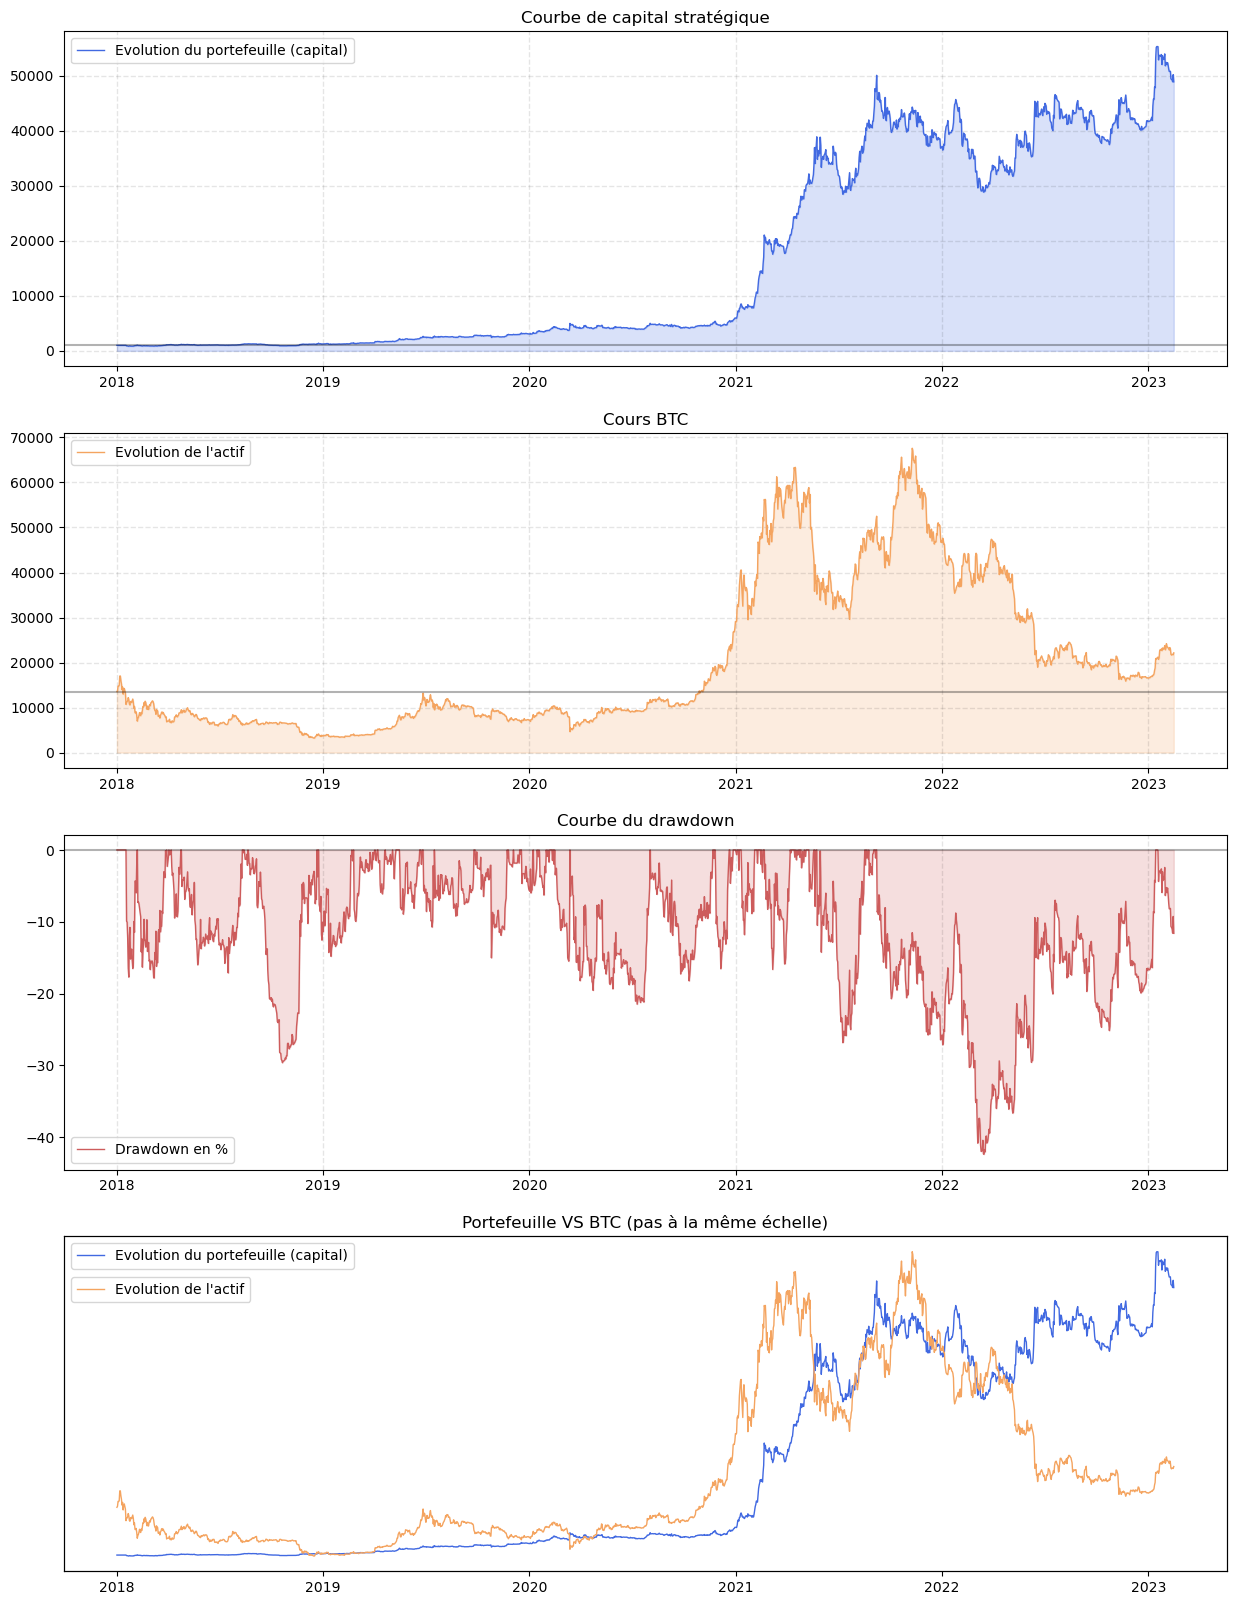

In [3]:
strat = super_reversion_strat(
    df_list=df_list,
    oldest_pair=oldest_pair,
    parameters_obj=params_coin,
    type=["long","short"]
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")

df_trades, df_days = basic_multi_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=df_days, pair=oldest_pair)

In [4]:
df_trades["trade_result_pct_wallet"].std()

0.020750817699474747

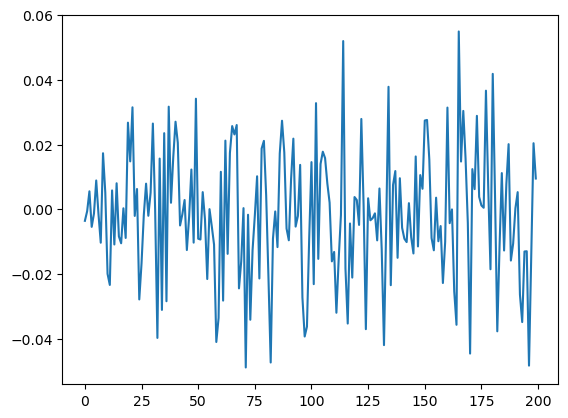

In [5]:
plt.plot(np.random.normal(0, 0.02, 200))

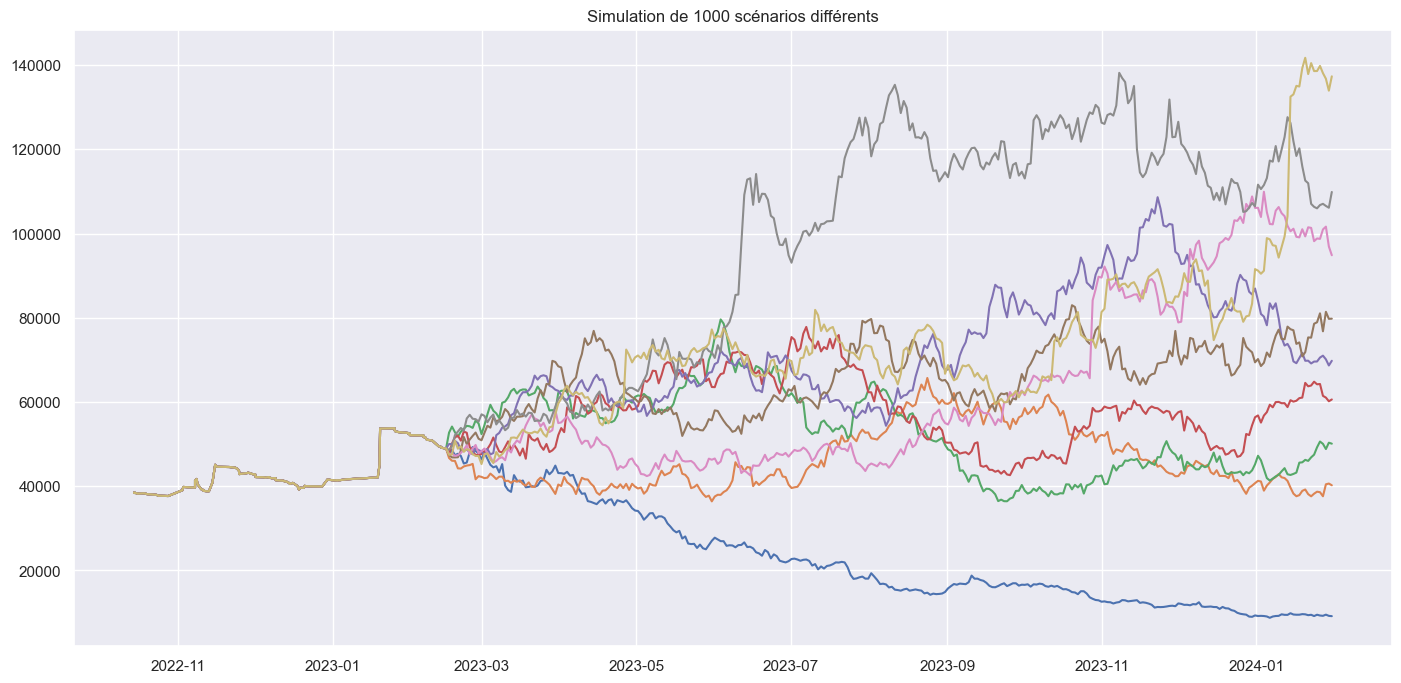

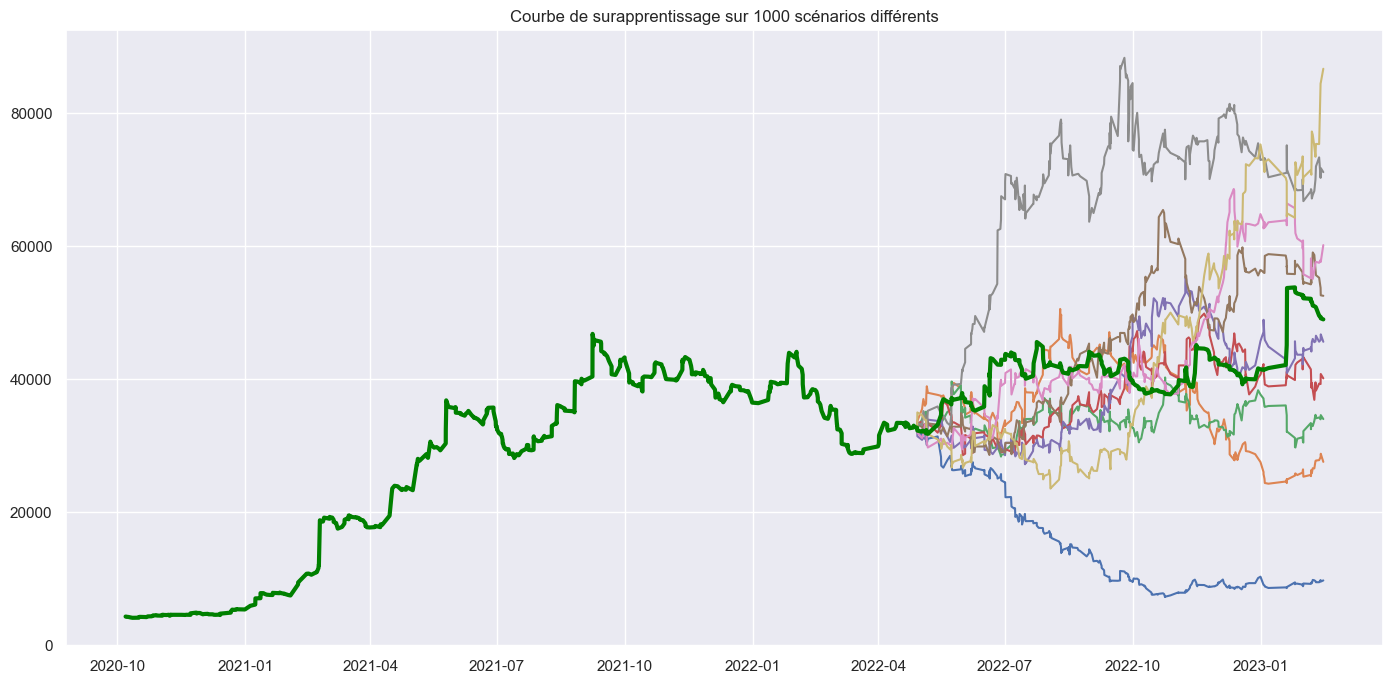

In [6]:
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=300,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=False
)
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2022-04-29",
    trades_multiplier=3,
    number_of_simulations=1000,
)

----- 2018 Performances cumulées: 25.66% --


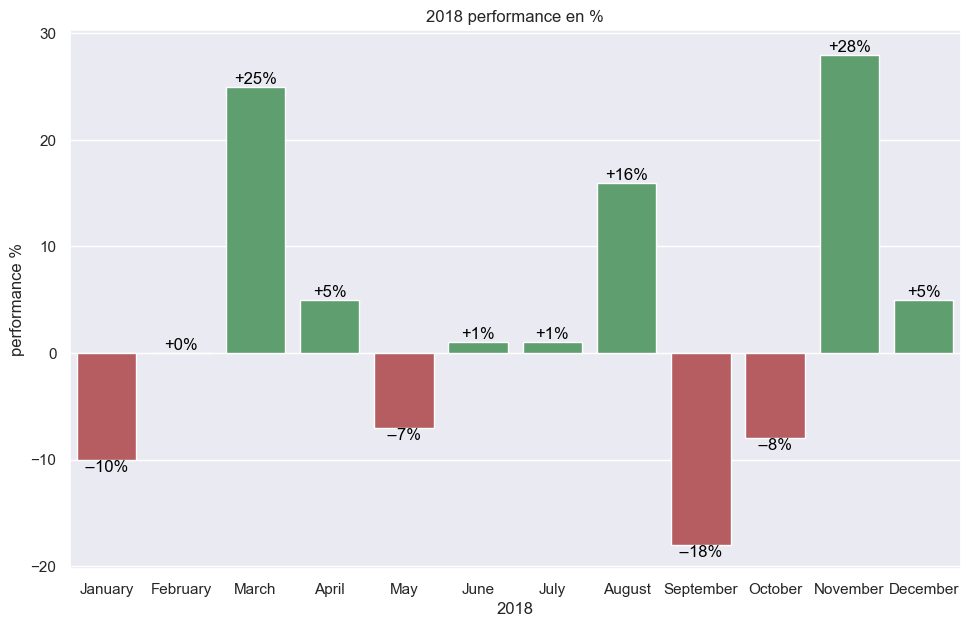

----- 2019 Performances cumulées: 148.09% --


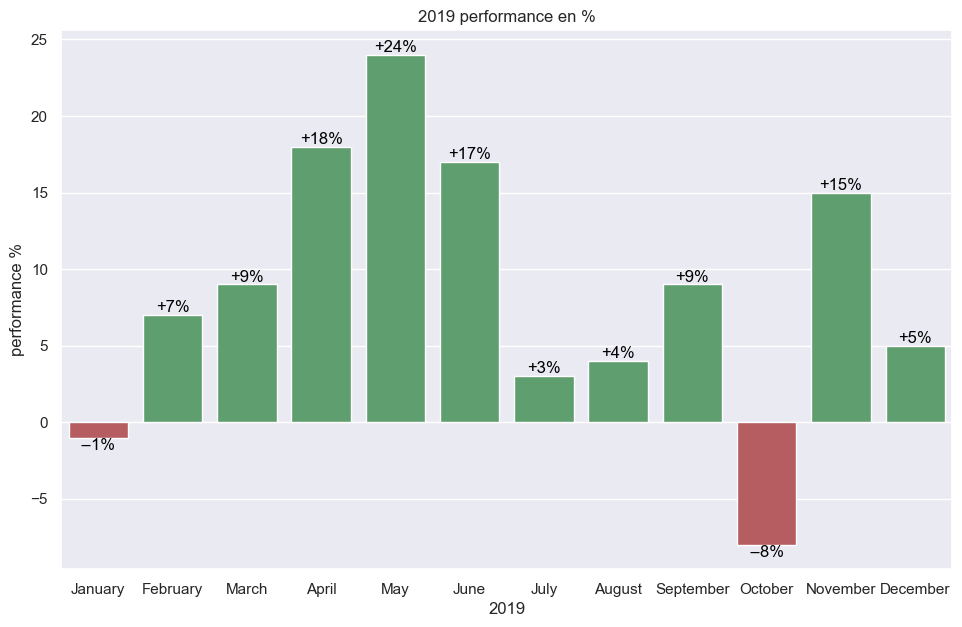

----- 2020 Performances cumulées: 94.93% --


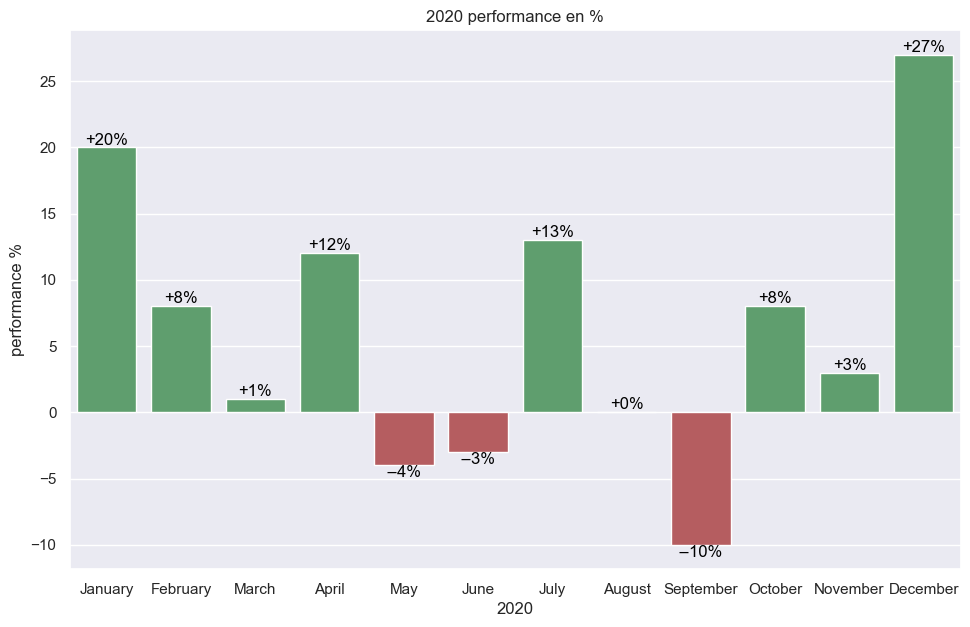

----- 2021 Performances cumulées: 521.84% --


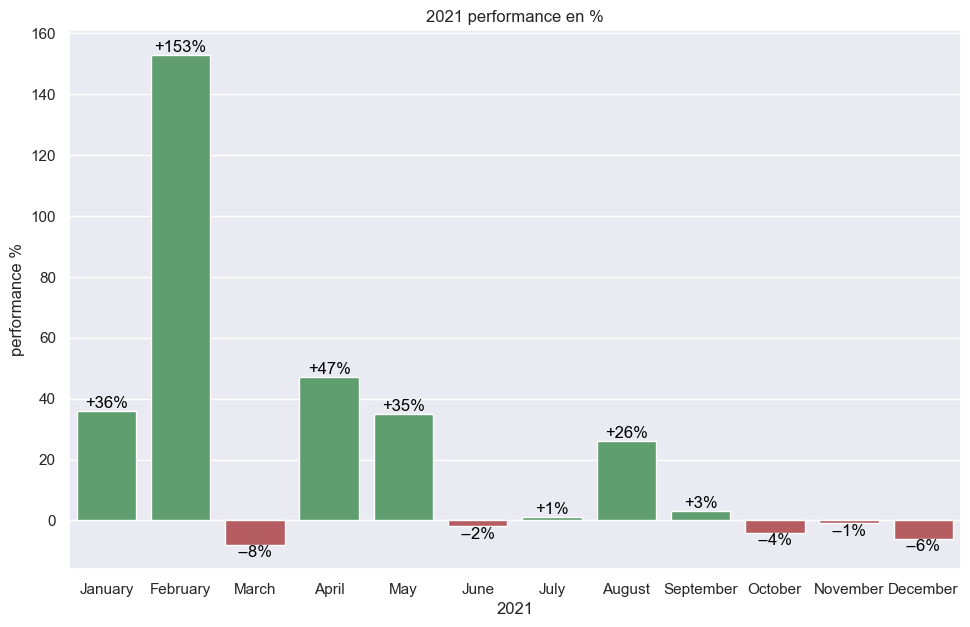

----- 2022 Performances cumulées: 12.51% --


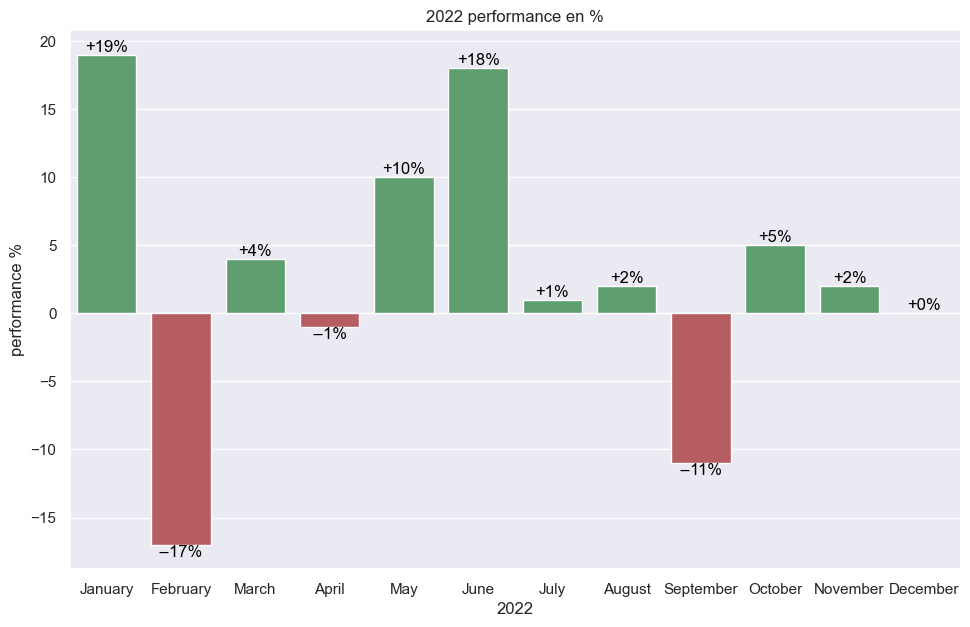

----- 2023 Performances cumulées: 17.19% --


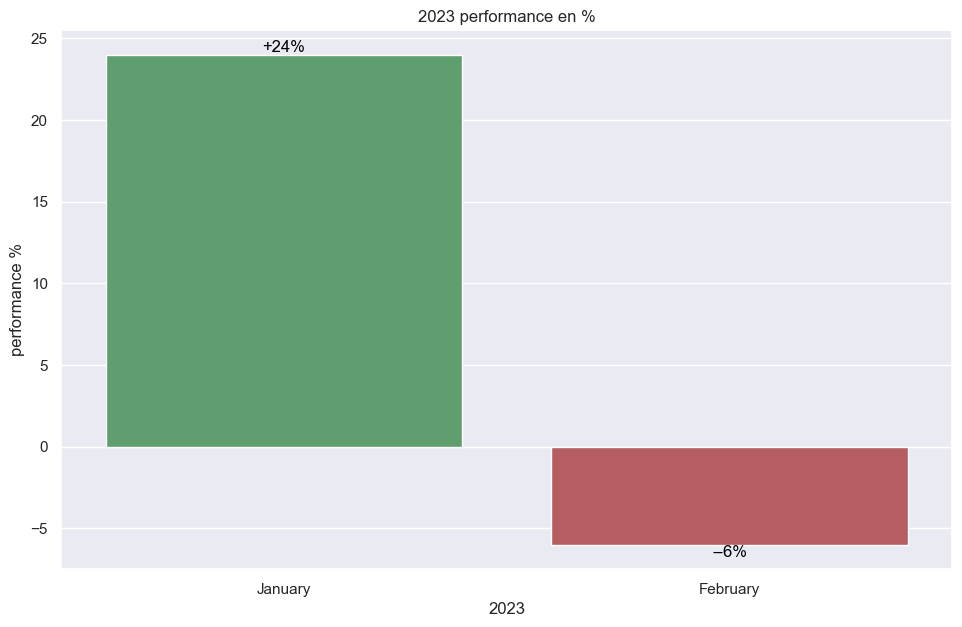

In [7]:
plot_bar_by_month(df_days=df_days)